# Analysis of Results
* Results were computed in `Evaluation.ipynb`
* In this notebook, we play with the results to gain further insights.

In [ ]:
import os
from os.path import join
from scripts.scoring import create_matrix_from_csv

res_files = os.listdir('direct_results')
direct_res = {f.replace('.csv', ''):{'file':join('direct_results', f), 'BLEU':None} for f in res_files}

for rs, content in direct_res.items():
    file_path = content['file']
    df = create_matrix_from_csv(file_path)
    direct_res[rs]['BLEU'] = df
    
    
res_files = os.listdir('post_results')
post_res = {f.replace('.csv', ''): {'file': join(
    'post_results', f)} for f in res_files}

for rs, content in post_res.items():
    file_path = content['file']
    df_bleu = create_matrix_from_csv(file_path)
    df_chrf = create_matrix_from_csv(file_path, metric='chrF')
    post_res[rs]['BLEU'] = df_bleu
    post_res[rs]['CHRF'] = df_chrf

res_files = os.listdir('post_results_split')
post_res_split = {f.replace('.csv', ''): {'file': join(
    'post_results_split', f), 'BLEU': None, 'CHRF': None} for f in res_files}

for rs, content in post_res_split.items():
    file_path = content['file']
    df_bleu = create_matrix_from_csv(file_path)
    df_chrf = create_matrix_from_csv(file_path, metric='chrF')
    post_res_split[rs]['BLEU'] = df_bleu
    post_res_split[rs]['CHRF'] = df_chrf

## Pearson Correlation

* Correlation between both translators
* We perform this on the direct aligned and post aligned results
    * Direct: We literally computed BLEU scores directly on the translation, without doing any alignments.
    * Post: We applied `bertalign` and sentence splitting to align everything nicely.

In [37]:
import numpy as np
from scipy.stats import pearsonr
# ChatGPT aided
parts = ['ep', 'flores', 'opus']
print('direct_results')
for part in parts:
    gpt = f'{part}-gpt'
    deepl = f'{part}-deepl'
    gpt_df = direct_res[gpt]['BLEU']
    deepl_df = direct_res[deepl]['BLEU']

    # flattens whole matrix into 1D-array
    gpt_flat = gpt_df.values.flatten()
    deepl_flat = deepl_df.values.flatten()

    mask = ~np.isnan(gpt_flat) & ~np.isnan(deepl_flat)

    # Compute Pearson correlation
    corr, pval = pearsonr(gpt_flat[mask], deepl_flat[mask])
    print(part)
    print(f"Pearson correlation: {corr:.2f}")
    print(f"p-value: {pval:.3f}")
    print()
    
print('post_results_with_bertalign_and_sentence_split')
for part in parts:
    gpt = f'{part}-gpt'
    deepl = f'{part}-deepl'
    gpt_df = post_res[gpt]['BLEU']
    deepl_df = post_res[deepl]['BLEU']

    gpt_flat = gpt_df.values.flatten()
    deepl_flat = deepl_df.values.flatten()

    mask = ~np.isnan(gpt_flat) & ~np.isnan(deepl_flat)

    # Compute Pearson correlation
    corr, pval = pearsonr(gpt_flat[mask], deepl_flat[mask])
    print(part)
    print(f"Pearson correlation: {corr:.2f}")
    print(f"p-value: {pval:.3f}")
    print()
    
print('post_results_with_bertalign')
for part in parts:
    gpt = f'{part}-gpt'
    deepl = f'{part}-deepl'
    gpt_df = post_res_split[gpt]['BLEU']
    deepl_df = post_res_split[deepl]['BLEU']

    gpt_flat = gpt_df.values.flatten()
    deepl_flat = deepl_df.values.flatten()

    mask = ~np.isnan(gpt_flat) & ~np.isnan(deepl_flat)

    # Compute Pearson correlation
    corr, pval = pearsonr(gpt_flat[mask], deepl_flat[mask])
    print(part)
    print(f"Pearson correlation: {corr:.2f}")
    print(f"p-value: {pval:.3f}")
    print()
    

direct_results
ep
Pearson correlation: 0.61
p-value: 0.000

flores
Pearson correlation: 0.80
p-value: 0.000

opus
Pearson correlation: 0.30
p-value: 0.206

post_results_with_bertalign
ep
Pearson correlation: 0.93
p-value: 0.000

flores
Pearson correlation: 0.96
p-value: 0.000

opus
Pearson correlation: 0.96
p-value: 0.000

post_results_without_bertalign
ep
Pearson correlation: 0.94
p-value: 0.000

flores
Pearson correlation: 0.96
p-value: 0.000

opus
Pearson correlation: 0.97
p-value: 0.000



* Observe, statistical significance went up after alignment, especially for OPUS100

Slope: 0.999, Intercept: -1.728


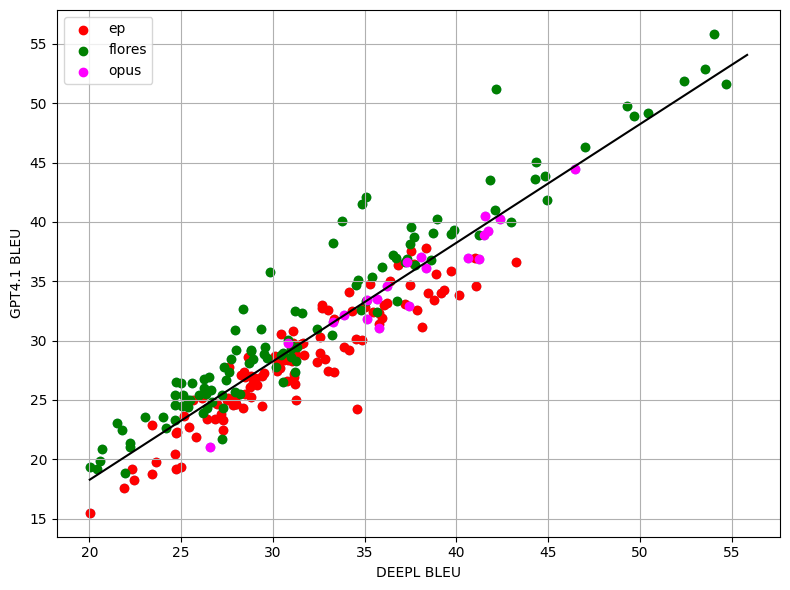

In [250]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# ChatGPT aided
deepl_scores, gpt_scores = [], []
labels = []

datasets = ['ep', 'flores', 'opus']
for ds in datasets:
    deepl_df = post_res[f'{ds}-deepl']['BLEU']
    gpt_df = post_res[f'{ds}-gpt']['BLEU']
    for src in deepl_df.index:
        for tgt in deepl_df.columns:
            if src==tgt:
                continue
            deepl_score = deepl_df.loc[src, tgt]
            gpt_score = gpt_df.loc[src, tgt]
            if pd.isna(deepl_score) or pd.isna(gpt_score):
                continue
            deepl_scores.append(deepl_score)
            gpt_scores.append(gpt_score)
            labels.append(f'{ds}-{src}-{tgt}')

deepl_s = np.array(deepl_scores)
gpt_s = np.array(gpt_scores)




# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(deepl_s, gpt_s, alpha=0.6)

model = np.polyfit(deepl_s, gpt_s, 1)


for ds, col in zip(datasets, ['red', 'green', 'magenta']):
    selected = [idx for idx, label in enumerate(
        labels) if label.startswith(ds)]
    plt.scatter(
        deepl_s[selected],
        gpt_s[selected],
        color=col,
        label=ds
    )

x_line = np.linspace(min(deepl_s), max(gpt_s), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')

print(f'Slope: {model[0]:.3f}, Intercept: {model[1]:.3f}')

plt.xlabel("DEEPL BLEU")
plt.ylabel("GPT4.1 BLEU")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

Slope: 1.004, Intercept: -1.136


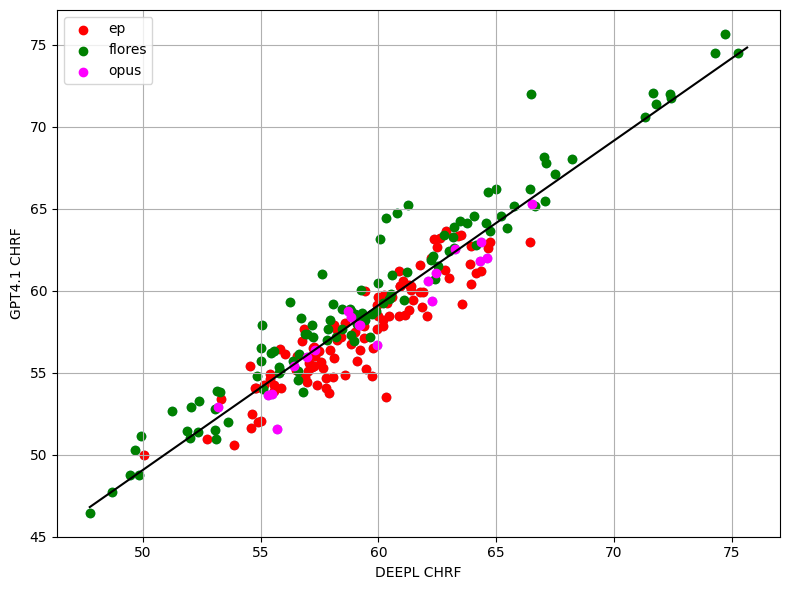

In [251]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# ChatGPT aided
deepl_scores, gpt_scores = [], []
labels = []

datasets = ['ep', 'flores', 'opus']
for ds in datasets:
    deepl_df = post_res[f'{ds}-deepl']['CHRF']
    gpt_df = post_res[f'{ds}-gpt']['CHRF']
    for src in deepl_df.index:
        for tgt in deepl_df.columns:
            if src == tgt:
                continue
            deepl_score = deepl_df.loc[src, tgt]
            gpt_score = gpt_df.loc[src, tgt]
            if pd.isna(deepl_score) or pd.isna(gpt_score):
                continue
            deepl_scores.append(deepl_score)
            gpt_scores.append(gpt_score)
            labels.append(f'{ds}-{src}-{tgt}')

deepl_s = np.array(deepl_scores)
gpt_s = np.array(gpt_scores)


# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(deepl_s, gpt_s, alpha=0.6)

model = np.polyfit(deepl_s, gpt_s, 1)


for ds, col in zip(datasets, ['red', 'green', 'magenta']):
    selected = [idx for idx, label in enumerate(
        labels) if label.startswith(ds)]
    plt.scatter(
        deepl_s[selected],
        gpt_s[selected],
        color=col,
        label=ds
    )

x_line = np.linspace(min(deepl_s), max(gpt_s), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')

print(f'Slope: {model[0]:.3f}, Intercept: {model[1]:.3f}')

plt.xlabel("DEEPL CHRF")
plt.ylabel("GPT4.1 CHRF")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

* Next, we compute correlation between BLEU and CHRF scores.

In [10]:
import numpy as np
from scipy.stats import pearsonr

parts = ['ep', 'flores', 'opus']
translators = ['deepl', 'gpt']

for part in parts:
    for tl in translators:
        key = f'{part}-{tl}'
        bleu_mat = post_res[key]['BLEU']
        chrf_mat = post_res[key]['CHRF']
        
        
        bleu_flat = bleu_mat.values.flatten()
        chrf_flat = chrf_mat.values.flatten()

        mask = ~np.isnan(bleu_flat) & ~np.isnan(chrf_flat)

        corr, pval = pearsonr(bleu_flat[mask], chrf_flat[mask])
        print(part, tl)
        print(f"Pearson correlation: {corr:.2f}")
        print(f"p-value: {pval:.5f}")
        print()

ep deepl
Pearson correlation: 0.83
p-value: 0.00000

ep gpt
Pearson correlation: 0.87
p-value: 0.00000

flores deepl
Pearson correlation: 0.94
p-value: 0.00000

flores gpt
Pearson correlation: 0.95
p-value: 0.00000

opus deepl
Pearson correlation: 0.85
p-value: 0.00000

opus gpt
Pearson correlation: 0.88
p-value: 0.00000



### Plotting

In [11]:
from collections import defaultdict

def topk_label_based_on_freq(labels, k=3):
    freq_dict = defaultdict(int)
    for l in labels:
        from_l, to_l = l.split('-')
        freq_dict[f'to-{to_l}'] += 1
        freq_dict[f'from-{from_l}'] += 1
    
    print(f'top {k}')
    for idx, (key, v) in enumerate(sorted(freq_dict.items(), key=lambda x : x[1], reverse=True)):
        if idx >= k:
            break
        print('\t', key)
    return freq_dict

* Let's do some graphing on EuroParl, DeepL, has the lowest Pearson correlation compared to the others

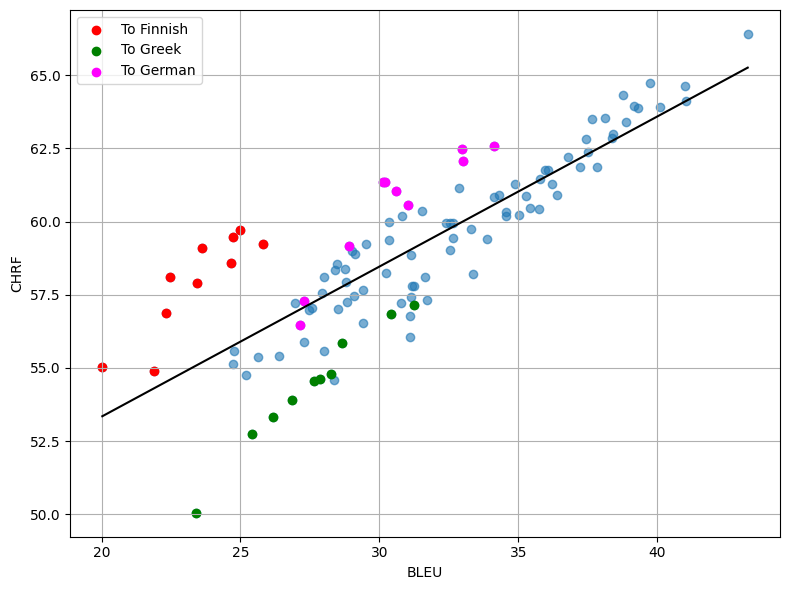

In [12]:
import matplotlib.pyplot as plt
# ChatGPT aided

bleu = post_res['ep-deepl']['BLEU']
chrf = post_res['ep-deepl']['CHRF']

bleu_vals, chrf_vals = [], []
labels = []

for src in bleu.index:
    for tgt in bleu.columns:
        if src==tgt:
            continue
        bs = bleu.loc[src, tgt]
        cs = chrf.loc[src, tgt]
        bleu_vals.append(bs)
        chrf_vals.append(cs)
        labels.append(f'{src}-{tgt}')


bleu_vals_np = np.array(bleu_vals)
chrf_vals_np = np.array(chrf_vals)


# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(bleu_vals, chrf_vals, alpha=0.6)

model = np.polyfit(bleu_vals_np, chrf_vals_np, 1)


to_finnish = [idx for idx, pair in enumerate(labels) if pair.endswith('fi')]
to_greek = [idx for idx, pair in enumerate(labels) if pair.endswith('el')]
to_german = [idx for idx, pair in enumerate(labels) if pair.endswith('de')]

plt.scatter(
    bleu_vals_np[to_finnish],
    chrf_vals_np[to_finnish],
    color='red',
    label='To Finnish'
)

plt.scatter(
    bleu_vals_np[to_greek],
    chrf_vals_np[to_greek],
    color='green',
    label='To Greek'
)

plt.scatter(
    bleu_vals_np[to_german],
    chrf_vals_np[to_german],
    color='magenta',
    label='To German'
)



x_line = np.linspace(min(bleu_vals_np), max(bleu_vals_np), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')


plt.xlabel("BLEU")
plt.ylabel("CHRF")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [13]:
# Based on: https://data36.com/linear-regression-in-python-numpy-polyfit/
# ChatGPT aided as well
predicted_chrf = np.poly1d(model)(bleu_vals_np)
residuals = abs(chrf_vals_np - predicted_chrf)

top_n = 20
outlier_indices = np.argsort(residuals)[-top_n:]

outlier_labels = []
for idx in outlier_indices:
    print(f"{labels[idx]} {bleu_vals_np[idx]:.1f}, {chrf_vals_np[idx]:.2f}")
    outlier_labels.append(labels[idx])

_ = topk_label_based_on_freq(outlier_labels)

sv-fi 22.3, 56.87
es-de 33.0, 62.50
fr-el 27.6, 54.55
sv-el 27.9, 54.63
da-el 28.3, 54.79
el-de 30.2, 61.36
pt-fi 23.4, 57.89
fr-de 30.1, 61.37
de-fi 24.7, 58.59
da-fi 25.8, 59.23
de-el 26.9, 53.89
nl-es 31.1, 56.04
nl-pt 28.4, 54.58
it-el 26.2, 53.31
fi-el 25.4, 52.74
fr-fi 22.4, 58.09
en-fi 24.7, 59.46
es-fi 25.0, 59.71
el-fi 23.6, 59.11
nl-el 23.4, 50.05
top 3
	 to-fi
	 to-el
	 to-de


* Iterative process, this was done first, then To German, To Finnish and To Greek pairs were marked.
* The graph tells us that CHRF considers quality of into Finnish translations higher and into Greek lower than BLEU.

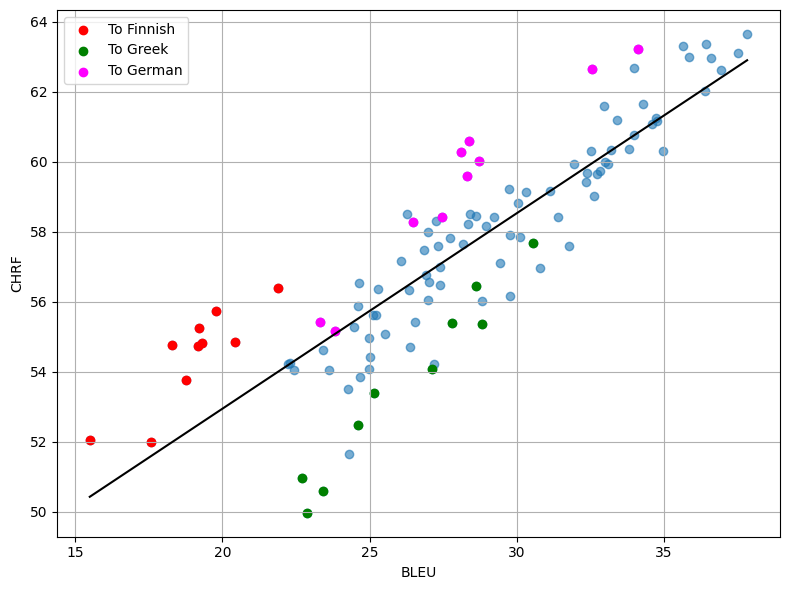

In [14]:
import matplotlib.pyplot as plt
# ChatGPT aided

bleu = post_res['ep-gpt']['BLEU']
chrf = post_res['ep-gpt']['CHRF']

bleu_vals, chrf_vals = [], []
labels = []

for src in bleu.index:
    for tgt in bleu.columns:
        if src == tgt:
            continue
        bs = bleu.loc[src, tgt]
        cs = chrf.loc[src, tgt]
        bleu_vals.append(bs)
        chrf_vals.append(cs)
        labels.append(f'{src}-{tgt}')


bleu_vals_np = np.array(bleu_vals)
chrf_vals_np = np.array(chrf_vals)


# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(bleu_vals, chrf_vals, alpha=0.6)

model = np.polyfit(bleu_vals_np, chrf_vals_np, 1)


to_finnish = [idx for idx, pair in enumerate(labels) if pair.endswith('fi')]
to_greek = [idx for idx, pair in enumerate(labels) if pair.endswith('el')]
to_german = [idx for idx, pair in enumerate(labels) if pair.endswith('de')]

plt.scatter(
    bleu_vals_np[to_finnish],
    chrf_vals_np[to_finnish],
    color='red',
    label='To Finnish'
)

plt.scatter(
    bleu_vals_np[to_greek],
    chrf_vals_np[to_greek],
    color='green',
    label='To Greek'
)

plt.scatter(
    bleu_vals_np[to_german],
    chrf_vals_np[to_german],
    color='magenta',
    label='To German'
)


x_line = np.linspace(min(bleu_vals_np), max(bleu_vals_np), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')


plt.xlabel("BLEU")
plt.ylabel("CHRF")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [15]:
# Based on: https://data36.com/linear-regression-in-python-numpy-polyfit/
# ChatGPT aided as well
predicted_chrf = np.poly1d(model)(bleu_vals_np)
residuals = abs(chrf_vals_np - predicted_chrf)

top_n = 20
outlier_indices = np.argsort(residuals)[-top_n:]

outlier_labels = []
for idx in outlier_indices:
    print(f"{labels[idx]} {bleu_vals_np[idx]:.1f}, {chrf_vals_np[idx]:.2f}")
    outlier_labels.append(labels[idx])

_ = topk_label_based_on_freq(outlier_labels)

sv-fi 19.2, 54.72
nl-es 29.8, 56.16
es-fi 19.3, 54.81
da-fi 21.9, 56.38
da-de 34.1, 63.22
it-el 25.2, 53.40
en-el 28.8, 55.36
es-de 32.6, 62.64
de-pt 27.2, 54.23
en-fi 19.2, 55.25
fr-fi 18.3, 54.76
el-de 28.1, 60.28
da-el 27.1, 54.07
el-fi 19.8, 55.72
pt-de 28.4, 60.60
sv-el 24.6, 52.46
fi-el 22.7, 50.96
nl-pt 24.3, 51.65
de-el 23.4, 50.60
nl-el 22.9, 49.97
top 3
	 to-el
	 to-fi
	 to-de


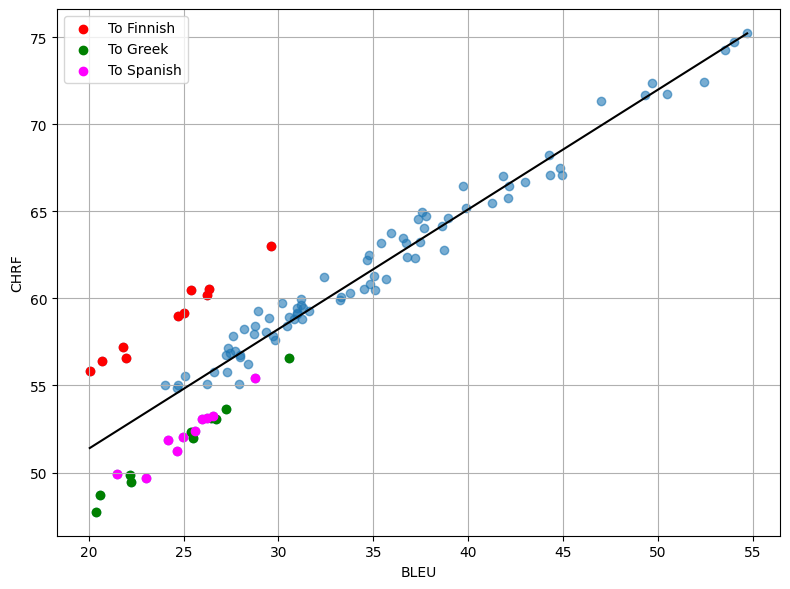

In [16]:
import matplotlib.pyplot as plt
# ChatGPT aided

bleu = post_res['flores-deepl']['BLEU']
chrf = post_res['flores-deepl']['CHRF']

bleu_vals, chrf_vals = [], []
labels = []

for src in bleu.index:
    for tgt in bleu.columns:
        if src == tgt:
            continue
        bs = bleu.loc[src, tgt]
        cs = chrf.loc[src, tgt]
        bleu_vals.append(bs)
        chrf_vals.append(cs)
        labels.append(f'{src}-{tgt}')


bleu_vals_np = np.array(bleu_vals)
chrf_vals_np = np.array(chrf_vals)


# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(bleu_vals, chrf_vals, alpha=0.6)

model = np.polyfit(bleu_vals_np, chrf_vals_np, 1)


to_finnish = [idx for idx, pair in enumerate(labels) if pair.endswith('fi')]
to_greek = [idx for idx, pair in enumerate(labels) if pair.endswith('el')]
to_spanish = [idx for idx, pair in enumerate(labels) if pair.endswith('es')]

plt.scatter(
    bleu_vals_np[to_finnish],
    chrf_vals_np[to_finnish],
    color='red',
    label='To Finnish'
)

plt.scatter(
    bleu_vals_np[to_greek],
    chrf_vals_np[to_greek],
    color='green',
    label='To Greek'
)

plt.scatter(
    bleu_vals_np[to_spanish],
    chrf_vals_np[to_spanish],
    color='magenta',
    label='To Spanish'
)


x_line = np.linspace(min(bleu_vals_np), max(bleu_vals_np), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')


plt.xlabel("BLEU")
plt.ylabel("CHRF")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [17]:
# Based on: https://data36.com/linear-regression-in-python-numpy-polyfit/
# ChatGPT aided as well
predicted_chrf = np.poly1d(model)(bleu_vals_np)
residuals = abs(chrf_vals_np - predicted_chrf)

threshold = 3
outlier_indices = np.where(residuals > threshold)[0]

top_n = 20
outlier_indices = np.argsort(residuals)[-top_n:]

outlier_labels = []
for idx in outlier_indices:
    print(f"{labels[idx]} {bleu_vals_np[idx]:.1f}, {chrf_vals_np[idx]:.2f}")
    outlier_labels.append(labels[idx])

_ = topk_label_based_on_freq(outlier_labels)

fr-el 25.4, 52.35
sv-es 25.6, 52.40
sv-el 26.7, 53.07
it-el 22.2, 49.83
es-el 20.6, 48.71
de-el 25.5, 52.01
el-es 24.7, 51.24
fi-el 22.2, 49.45
nl-es 23.0, 49.67
nl-fi 22.0, 56.56
nl-el 20.4, 47.75
fr-fi 25.0, 59.17
pt-fi 24.7, 58.99
es-fi 20.1, 55.84
de-fi 26.3, 60.18
it-fi 20.7, 56.38
el-fi 21.8, 57.21
da-fi 26.3, 60.54
en-fi 29.6, 62.99
sv-fi 25.4, 60.47
top 3
	 to-fi
	 to-el
	 to-es


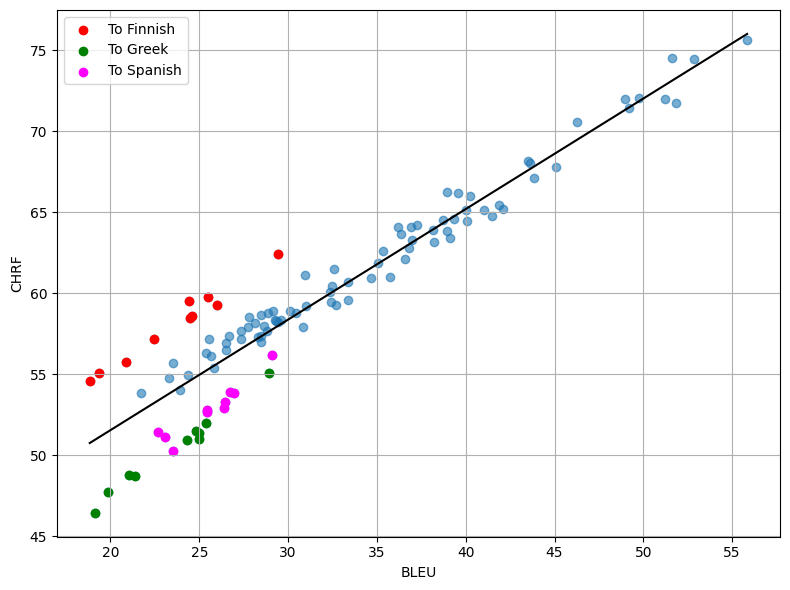

In [18]:
import matplotlib.pyplot as plt
# ChatGPT aided

bleu = post_res['flores-gpt']['BLEU']
chrf = post_res['flores-gpt']['CHRF']

bleu_vals, chrf_vals = [], []
labels = []

for src in bleu.index:
    for tgt in bleu.columns:
        if src == tgt:
            continue
        bs = bleu.loc[src, tgt]
        cs = chrf.loc[src, tgt]
        bleu_vals.append(bs)
        chrf_vals.append(cs)
        labels.append(f'{src}-{tgt}')


bleu_vals_np = np.array(bleu_vals)
chrf_vals_np = np.array(chrf_vals)


# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(bleu_vals, chrf_vals, alpha=0.6)

model = np.polyfit(bleu_vals_np, chrf_vals_np, 1)


to_finnish = [idx for idx, pair in enumerate(labels) if pair.endswith('fi')]
to_greek = [idx for idx, pair in enumerate(labels) if pair.endswith('el')]
to_spanish = [idx for idx, pair in enumerate(labels) if pair.endswith('es')]


plt.scatter(
    bleu_vals_np[to_finnish],
    chrf_vals_np[to_finnish],
    color='red',
    label='To Finnish'
)

plt.scatter(
    bleu_vals_np[to_greek],
    chrf_vals_np[to_greek],
    color='green',
    label='To Greek'
)

plt.scatter(
    bleu_vals_np[to_spanish],
    chrf_vals_np[to_spanish],
    color='magenta',
    label='To Spanish'
)


x_line = np.linspace(min(bleu_vals_np), max(bleu_vals_np), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')


plt.xlabel("BLEU")
plt.ylabel("CHRF")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [19]:
# Based on: https://data36.com/linear-regression-in-python-numpy-polyfit/
# ChatGPT aided as well
predicted_chrf = np.poly1d(model)(bleu_vals_np)
residuals = abs(chrf_vals_np - predicted_chrf)

top_n = 30
outlier_indices = np.argsort(residuals)[-top_n:]

outlier_labels = []
for idx in outlier_indices:
    print(f"{labels[idx]} {bleu_vals_np[idx]:.1f}, {chrf_vals_np[idx]:.2f}")
    outlier_labels.append(labels[idx])

_ = topk_label_based_on_freq(outlier_labels)

it-es 22.7, 51.46
en-nl 30.9, 61.12
fr-es 26.7, 53.90
da-es 26.9, 53.85
pt-es 25.5, 52.81
fi-es 23.1, 51.12
en-el 28.9, 55.10
el-es 25.4, 52.69
sv-es 26.4, 53.29
de-es 26.4, 52.91
da-el 25.4, 52.01
sv-el 24.8, 51.48
it-el 21.1, 48.78
pt-el 24.3, 50.95
fr-el 25.0, 51.40
it-fi 20.9, 55.73
de-fi 26.0, 59.25
nl-es 23.5, 50.27
fi-el 21.4, 48.75
es-el 19.9, 47.72
nl-fi 18.8, 54.57
fr-fi 24.5, 58.47
pt-fi 24.6, 58.60
de-el 25.0, 51.01
el-fi 22.5, 57.20
es-fi 19.3, 55.10
en-fi 29.4, 62.43
da-fi 25.5, 59.77
nl-el 19.2, 46.46
sv-fi 24.4, 59.50
top 3
	 to-el
	 to-fi
	 to-es


## Bert-F1 & COMET

In [228]:

from os.path import join
from scripts.scoring import create_matrix_from_csv
ep_deepl_path = join('bert_comet', 'ep_deepl.csv')
ep_gpt_path = join('bert_comet', 'ep_gpt.csv')

data={'ep-deepl':{}, 'ep-gpt':{}}

data['ep-deepl']['BLEU'] = create_matrix_from_csv(ep_deepl_path, metric='BLEU')
data['ep-deepl']['BERT-F1'] = create_matrix_from_csv(ep_deepl_path, metric='BERT-F1')
data['ep-deepl']['COMET'] = create_matrix_from_csv(ep_deepl_path, metric='COMET')
data['ep-deepl']['CHRF'] = create_matrix_from_csv(ep_deepl_path, metric='chrF')


data['ep-gpt']['BLEU'] = create_matrix_from_csv(ep_gpt_path, metric='BLEU')
data['ep-gpt']['BERT-F1'] = create_matrix_from_csv(ep_gpt_path, metric='BERT-F1')
data['ep-gpt']['COMET'] = create_matrix_from_csv(ep_gpt_path, metric='COMET')
data['ep-gpt']['CHRF'] = create_matrix_from_csv(ep_gpt_path, metric='chrF')

In [229]:
import numpy as np
from scipy.stats import pearsonr

parts = ['ep']
translators = ['deepl', 'gpt']

for part in parts:
    for tl in translators:
        key = f'{part}-{tl}'
        bleu_mat = data[key]['BLEU']
        comet_mat = data[key]['COMET']

        bleu_flat = bleu_mat.values.flatten()
        comet_flat = comet_mat.values.flatten()

        mask = ~np.isnan(bleu_flat) & ~np.isnan(comet_flat)

        corr, pval = pearsonr(bleu_flat[mask], comet_flat[mask])
        print(part, tl)
        print(f"Pearson correlation: {corr:.2f}")
        print(f"p-value: {pval:.5f}")
        print()

ep deepl
Pearson correlation: -0.41
p-value: 0.00001

ep gpt
Pearson correlation: -0.35
p-value: 0.00022



In [230]:
import numpy as np
from scipy.stats import pearsonr

parts = ['ep']
translators = ['deepl', 'gpt']

for part in parts:
    for tl in translators:
        key = f'{part}-{tl}'
        bleu_mat = data[key]['BLEU']
        bert_mat = data[key]['BERT-F1']

        bleu_flat = bleu_mat.values.flatten()
        bert_flat = bert_mat.values.flatten()

        mask = ~np.isnan(bleu_flat) & ~np.isnan(bert_flat)

        corr, pval = pearsonr(bleu_flat[mask], bert_flat[mask])
        print(part, tl)
        print(f"Pearson correlation: {corr:.2f}")
        print(f"p-value: {pval:.5f}")
        print()

ep deepl
Pearson correlation: 0.04
p-value: 0.70939

ep gpt
Pearson correlation: 0.16
p-value: 0.09352



In [231]:
import numpy as np
from scipy.stats import pearsonr

parts = ['ep']
translators = ['deepl', 'gpt']

for part in parts:
    for tl in translators:
        key = f'{part}-{tl}'
        comet_mat = data[key]['COMET']
        bert_mat = data[key]['BERT-F1']

        comet_flat = comet_mat.values.flatten()
        bert_flat = bert_mat.values.flatten()

        mask = ~np.isnan(comet_flat) & ~np.isnan(bert_flat)

        corr, pval = pearsonr(comet_flat[mask], bert_flat[mask])
        print(part, tl)
        print(f"Pearson correlation: {corr:.2f}")
        print(f"p-value: {pval:.5f}")
        print()

ep deepl
Pearson correlation: 0.26
p-value: 0.00596

ep gpt
Pearson correlation: 0.33
p-value: 0.00046



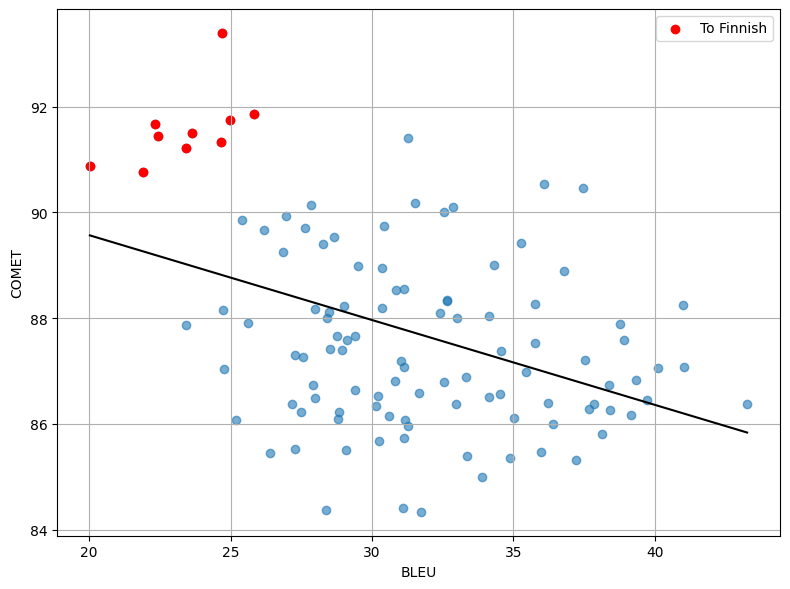

In [232]:
import matplotlib.pyplot as plt
import numpy as np
# ChatGPT aided

bleu = data['ep-deepl']['BLEU']
comet = data['ep-deepl']['COMET']

bleu_vals, comet_vals = [], []
labels = []

for src in bleu.index:
    for tgt in bleu.columns:
        if src == tgt:
            continue
        bs = bleu.loc[src, tgt]
        cs = comet.loc[src, tgt]
        bleu_vals.append(bs)
        comet_vals.append(cs)
        labels.append(f'{src}-{tgt}')


bleu_vals_np = np.array(bleu_vals)
comet_vals_np = np.array(comet_vals)


# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(bleu_vals, comet_vals, alpha=0.6)

model = np.polyfit(bleu_vals_np, comet_vals_np, 1)

to_finnish = [idx for idx, pair in enumerate(labels) if pair.endswith('fi')]

plt.scatter(
    bleu_vals_np[to_finnish],
    comet_vals_np[to_finnish],
    color='red',
    label='To Finnish'
)


x_line = np.linspace(min(bleu_vals_np), max(bleu_vals_np), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')


plt.xlabel("BLEU")
plt.ylabel("COMET")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

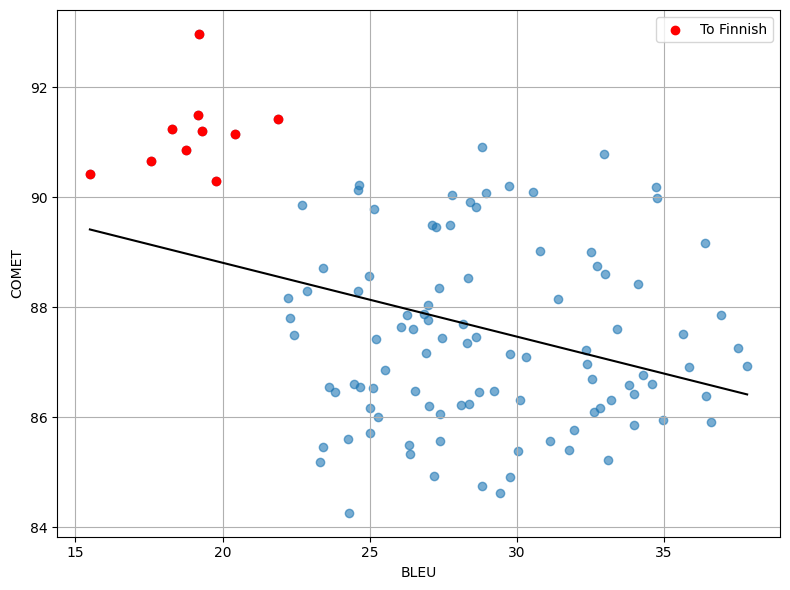

In [233]:
import matplotlib.pyplot as plt
import numpy as np
# ChatGPT aided

bleu = data['ep-gpt']['BLEU']
comet = data['ep-gpt']['COMET']

bleu_vals, comet_vals = [], []
labels = []

for src in bleu.index:
    for tgt in bleu.columns:
        if src == tgt:
            continue
        bs = bleu.loc[src, tgt]
        cs = comet.loc[src, tgt]
        bleu_vals.append(bs)
        comet_vals.append(cs)
        labels.append(f'{src}-{tgt}')


bleu_vals_np = np.array(bleu_vals)
comet_vals_np = np.array(comet_vals)


# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(bleu_vals, comet_vals, alpha=0.6)

model = np.polyfit(bleu_vals_np, comet_vals_np, 1)

to_finnish = [idx for idx, pair in enumerate(labels) if pair.endswith('fi')]

plt.scatter(
    bleu_vals_np[to_finnish],
    comet_vals_np[to_finnish],
    color='red',
    label='To Finnish'
)


x_line = np.linspace(min(bleu_vals_np), max(bleu_vals_np), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')


plt.xlabel("BLEU")
plt.ylabel("COMET")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [234]:
# Based on: https://data36.com/linear-regression-in-python-numpy-polyfit/
# ChatGPT aided as well
predicted_comet = np.poly1d(model)(bleu_vals_np)
residuals = abs(comet_vals_np - predicted_comet)

top_n = 30
outlier_indices = np.argsort(residuals)[-top_n:]

outlier_labels = []
for idx in outlier_indices:
    print(f"{labels[idx]} {bleu_vals_np[idx]:.1f}, {comet_vals_np[idx]:.2f}")
    outlier_labels.append(labels[idx])

_ = topk_label_based_on_freq(outlier_labels)

el-nl 25.3, 86.01
pt-el 28.6, 89.82
fr-fi 18.3, 91.25
en-sv 28.4, 89.92
es-nl 27.4, 85.57
fr-el 27.8, 90.04
es-fi 19.3, 91.19
de-fi 20.4, 91.15
sv-pt 25.0, 85.71
pt-nl 26.3, 85.50
fi-da 28.9, 90.07
es-da 36.4, 89.16
sv-fi 19.2, 91.49
nl-es 29.8, 84.91
da-pt 26.4, 85.33
en-pt 24.3, 85.61
da-sv 29.7, 90.21
es-el 30.6, 90.10
da-fi 21.9, 91.41
nl-fr 28.8, 84.76
it-nl 23.4, 85.47
de-pt 27.2, 84.92
it-en 29.4, 84.61
de-da 34.8, 89.98
it-de 23.3, 85.18
en-el 28.8, 90.91
en-da 34.7, 90.19
sv-da 33.0, 90.77
nl-pt 24.3, 84.26
en-fi 19.2, 92.97
top 3
	 to-fi
	 from-en
	 to-pt


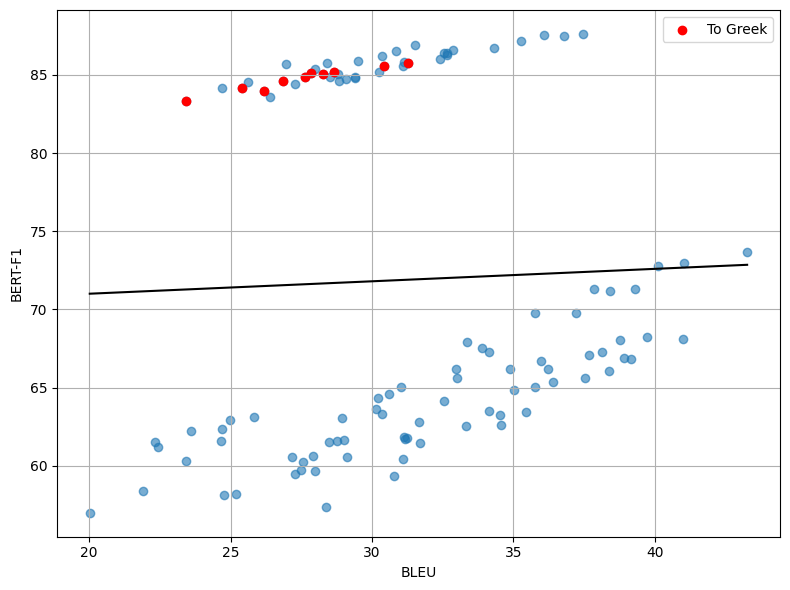

In [235]:
import matplotlib.pyplot as plt
import numpy as np
# ChatGPT aided

bleu = data['ep-deepl']['BLEU']
comet = data['ep-deepl']['BERT-F1']

bleu_vals, comet_vals = [], []
labels = []

for src in bleu.index:
    for tgt in bleu.columns:
        if src == tgt:
            continue
        bs = bleu.loc[src, tgt]
        cs = comet.loc[src, tgt]
        bleu_vals.append(bs)
        comet_vals.append(cs)
        labels.append(f'{src}-{tgt}')


bleu_vals_np = np.array(bleu_vals)
comet_vals_np = np.array(comet_vals)


# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(bleu_vals, comet_vals, alpha=0.6)

model = np.polyfit(bleu_vals_np, comet_vals_np, 1)

to_finnish = [idx for idx, pair in enumerate(labels) if pair.endswith('el')]

plt.scatter(
    bleu_vals_np[to_finnish],
    comet_vals_np[to_finnish],
    color='red',
    label='To Greek'
)


x_line = np.linspace(min(bleu_vals_np), max(bleu_vals_np), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')


plt.xlabel("BLEU")
plt.ylabel("BERT-F1")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [236]:
# Based on: https://data36.com/linear-regression-in-python-numpy-polyfit/
# ChatGPT aided as well
predicted_comet = np.poly1d(model)(bleu_vals_np)
residuals = abs(comet_vals_np - predicted_comet)

top_n = 30
outlier_indices = np.argsort(residuals)[-top_n:]

outlier_labels = []
for idx in outlier_indices:
    print(f"{labels[idx]} {bleu_vals_np[idx]:.1f}, {comet_vals_np[idx]:.2f}")
    outlier_labels.append(labels[idx])

_ = topk_label_based_on_freq(outlier_labels)

nl-it 25.2, 58.17
fi-it 24.8, 58.12
el-nl 28.8, 85.03
es-nl 30.2, 85.20
da-el 28.3, 85.05
sv-el 27.9, 85.09
pt-el 28.7, 85.17
nl-da 31.1, 85.54
es-el 30.4, 85.57
pt-sv 28.0, 85.39
en-el 31.3, 85.77
da-nl 31.1, 85.81
it-fi 20.0, 56.99
en-nl 32.4, 86.02
fr-sv 28.4, 85.73
fi-sv 27.0, 85.67
el-sv 29.5, 85.87
fr-da 32.7, 86.27
nl-pt 28.4, 57.35
fi-da 32.6, 86.38
pt-da 32.7, 86.41
de-sv 30.4, 86.24
el-da 34.3, 86.73
en-sv 32.9, 86.62
es-sv 30.8, 86.51
de-da 35.3, 87.15
da-sv 31.5, 86.93
es-da 36.8, 87.46
en-da 37.5, 87.62
sv-da 36.1, 87.57
top 3
	 to-da
	 to-sv
	 to-el


Slope: 0.973, Intercept: 2.273


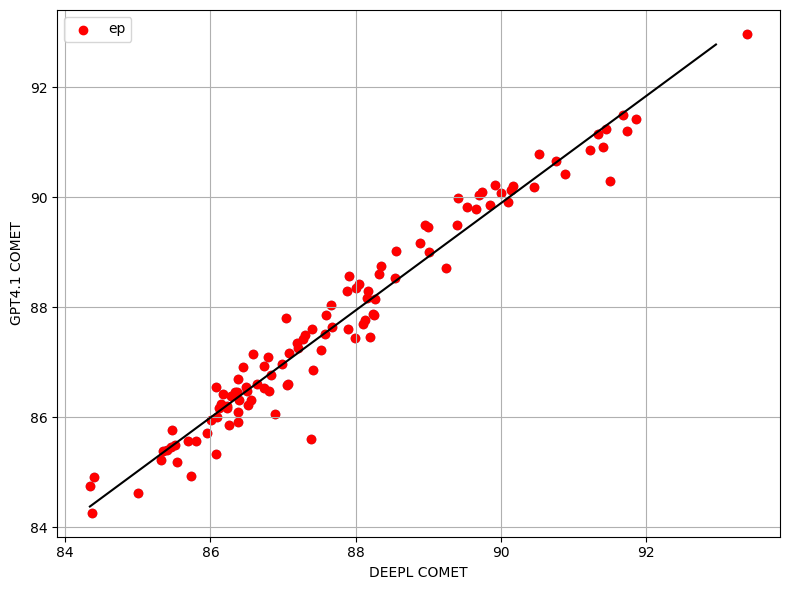

In [252]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# ChatGPT aided
deepl_scores, gpt_scores = [], []
labels = []

datasets = ['ep']
for ds in datasets:
    deepl_df = data[f'{ds}-deepl']['COMET']
    gpt_df = data[f'{ds}-gpt']['COMET']
    for src in deepl_df.index:
        for tgt in deepl_df.columns:
            if src == tgt:
                continue
            deepl_score = deepl_df.loc[src, tgt]
            gpt_score = gpt_df.loc[src, tgt]
            if pd.isna(deepl_score) or pd.isna(gpt_score):
                continue
            deepl_scores.append(deepl_score)
            gpt_scores.append(gpt_score)
            labels.append(f'{ds}-{src}-{tgt}')

deepl_s = np.array(deepl_scores)
gpt_s = np.array(gpt_scores)


# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(deepl_s, gpt_s, alpha=0.6)

model = np.polyfit(deepl_s, gpt_s, 1)
print(f'Slope: {model[0]:.3f}, Intercept: {model[1]:.3f}')


for ds, col in zip(datasets, ['red']):
    selected = [idx for idx, label in enumerate(
        labels) if label.startswith(ds)]
    plt.scatter(
        deepl_s[selected],
        gpt_s[selected],
        color=col,
        label=ds
    )

x_line = np.linspace(min(deepl_s), max(gpt_s), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')

plt.xlabel("DEEPL COMET")
plt.ylabel("GPT4.1 COMET")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

Slope: 1.061, Intercept: -5.441


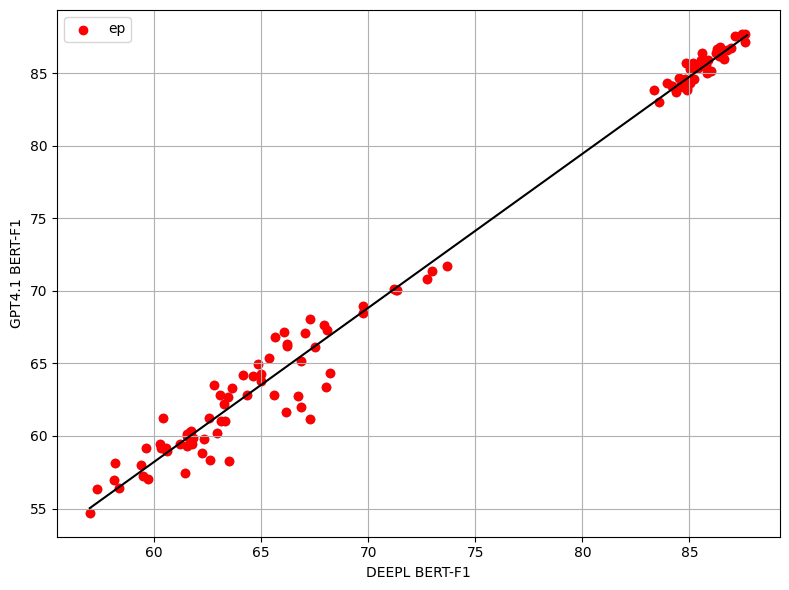

In [254]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# ChatGPT aided
deepl_scores, gpt_scores = [], []
labels = []

datasets = ['ep']
for ds in datasets:
    deepl_df = data[f'{ds}-deepl']['BERT-F1']
    gpt_df = data[f'{ds}-gpt']['BERT-F1']
    for src in deepl_df.index:
        for tgt in deepl_df.columns:
            if src == tgt:
                continue
            deepl_score = deepl_df.loc[src, tgt]
            gpt_score = gpt_df.loc[src, tgt]
            if pd.isna(deepl_score) or pd.isna(gpt_score):
                continue
            deepl_scores.append(deepl_score)
            gpt_scores.append(gpt_score)
            labels.append(f'{ds}-{src}-{tgt}')

deepl_s = np.array(deepl_scores)
gpt_s = np.array(gpt_scores)


# Plot all points
plt.figure(figsize=(8, 6))
plt.scatter(deepl_s, gpt_s, alpha=0.6)

model = np.polyfit(deepl_s, gpt_s, 1)
print(f'Slope: {model[0]:.3f}, Intercept: {model[1]:.3f}')


for ds, col in zip(datasets, ['red']):
    selected = [idx for idx, label in enumerate(
        labels) if label.startswith(ds)]
    plt.scatter(
        deepl_s[selected],
        gpt_s[selected],
        color=col,
        label=ds
    )

x_line = np.linspace(min(deepl_s), max(gpt_s), 100)
y_line = model[0] * x_line + model[1]
plt.plot(x_line, y_line, color='black')

plt.xlabel("DEEPL BERT-F1")
plt.ylabel("GPT4.1 BERT-F1")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

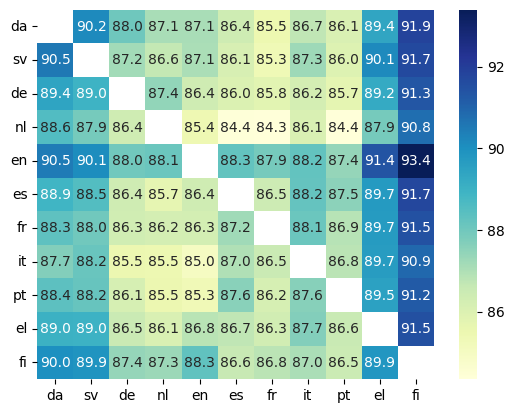

In [238]:
import seaborn as sns
import matplotlib.pyplot as plt
order = ['da', 'sv', 'de', 'nl', 'en', 'es', 'fr', 'it', 'pt', 'el', 'fi']
mat = data['ep-deepl']['COMET'].reindex(index=order, columns=order)
sns.heatmap(mat, annot=True, fmt=".1f",
            cmap="YlGnBu", cbar=True)
plt.yticks(rotation=0)
plt.show()

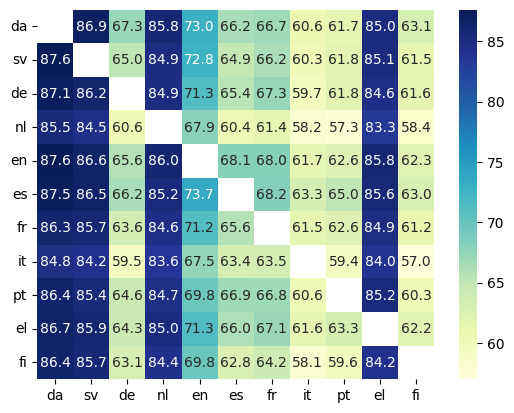

In [239]:
import seaborn as sns
import matplotlib.pyplot as plt
order = ['da', 'sv', 'de', 'nl', 'en', 'es', 'fr', 'it', 'pt', 'el', 'fi']
mat = data['ep-deepl']['BERT-F1'].reindex(index=order, columns=order)
sns.heatmap(mat, annot=True, fmt=".1f",
            cmap="YlGnBu", cbar=True)
plt.yticks(rotation=0)
plt.show()

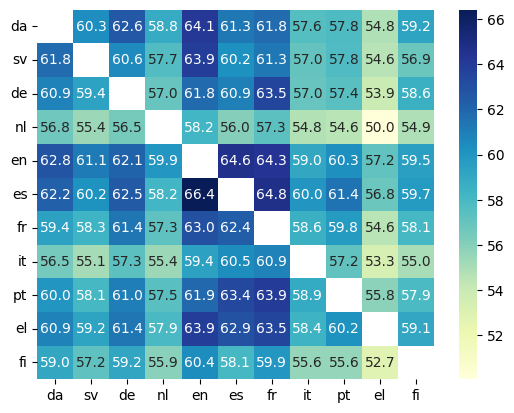

In [241]:
import seaborn as sns
import matplotlib.pyplot as plt
order = ['da', 'sv', 'de', 'nl', 'en', 'es', 'fr', 'it', 'pt', 'el', 'fi']
mat = data['ep-deepl']['CHRF'].reindex(index=order, columns=order)
sns.heatmap(mat, annot=True, fmt=".1f",
            cmap="YlGnBu", cbar=True)
plt.yticks(rotation=0)
plt.show()

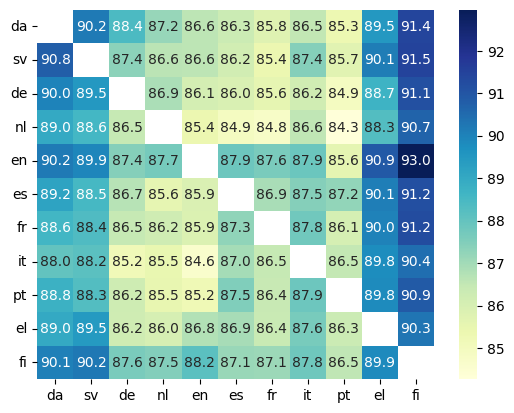

In [255]:
import seaborn as sns
import matplotlib.pyplot as plt
order = ['da', 'sv', 'de', 'nl', 'en', 'es', 'fr', 'it', 'pt', 'el', 'fi']
mat = data['ep-gpt']['COMET'].reindex(index=order, columns=order)
sns.heatmap(mat, annot=True, fmt=".1f",
            cmap="YlGnBu", cbar=True)
plt.yticks(rotation=0)
plt.show()

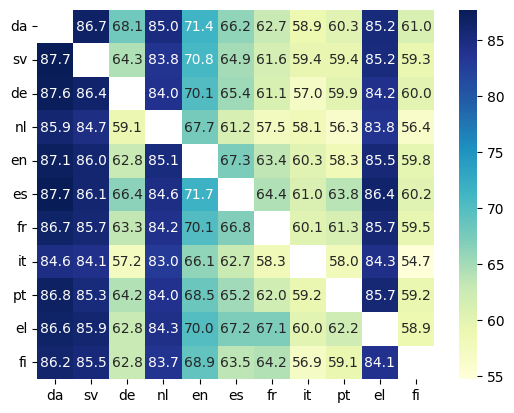

In [256]:
import seaborn as sns
import matplotlib.pyplot as plt
order = ['da', 'sv', 'de', 'nl', 'en', 'es', 'fr', 'it', 'pt', 'el', 'fi']
mat = data['ep-gpt']['BERT-F1'].reindex(index=order, columns=order)
sns.heatmap(mat, annot=True, fmt=".1f",
            cmap="YlGnBu", cbar=True)
plt.yticks(rotation=0)
plt.show()

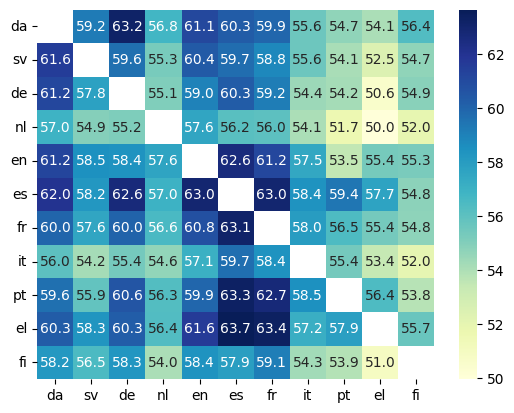

In [257]:
import seaborn as sns
import matplotlib.pyplot as plt
order = ['da', 'sv', 'de', 'nl', 'en', 'es', 'fr', 'it', 'pt', 'el', 'fi']
mat = data['ep-gpt']['CHRF'].reindex(index=order, columns=order)
sns.heatmap(mat, annot=True, fmt=".1f",
            cmap="YlGnBu", cbar=True)
plt.yticks(rotation=0)
plt.show()

## Aggregations

In [187]:
import pandas as pd
import numpy as np
# Created with Claude 3.7 Sonnet
# Transcribed from: https://aclanthology.org/2005.mtsummit-papers.11.pdf
data = {
    'da': [np.nan, 22.3, 22.7, 25.2, 24.1, 23.7, 20.0, 21.4, 20.5, 23.2, 30.3],
    'de': [18.4, np.nan, 17.4, 17.6, 18.2, 18.5, 14.5, 16.9, 18.3, 18.2, 18.9],
    'el': [21.1, 20.7, np.nan, 23.2, 28.3, 26.1, 18.2, 24.8, 17.4, 26.4, 22.8],
    'en': [28.5, 25.3, 27.2, np.nan, 30.5, 30.0, 21.8, 27.8, 23.0, 30.1, 30.2],
    'es': [26.4, 25.4, 31.2, 30.1, np.nan, 38.4, 21.1, 34.0, 22.9, 37.9, 28.6],
    'fr': [28.7, 27.7, 32.1, 31.1, 40.2, np.nan, 22.4, 36.0, 24.6, 39.0, 29.7],
    'fi': [14.2, 11.8, 11.4, 13.0, 12.5, 12.6, np.nan, 11.0, 10.3, 11.9, 15.3],
    'it': [22.2, 21.3, 26.8, 25.3, 32.3, 32.4, 18.3, np.nan, 20.0, 32.0, 23.9],
    'nl': [21.4, 23.4, 20.0, 21.0, 21.4, 21.1, 17.0, 20.0, np.nan, 20.2, 21.9],
    'pt': [24.3, 23.2, 27.6, 27.1, 35.9, 35.3, 19.1, 31.2, 20.7, np.nan, 25.9],
    'sv': [28.3, 20.5, 21.2, 24.8, 23.9, 22.6, 18.8, 20.2, 19.0, 21.9, np.nan]
}

languages = ['da', 'de', 'el', 'en', 'es', 'fr', 'fi', 'it', 'nl', 'pt', 'sv']
koehn_2005 = pd.DataFrame(data, index=languages)

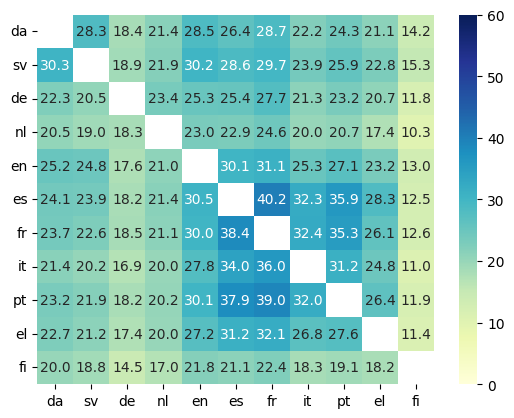

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt

order = ['da', 'sv', 'de', 'nl', 'en', 'es', 'fr', 'it', 'pt', 'el', 'fi']
koehn_2005 = koehn_2005.reindex(index=order, columns=order)
sns.heatmap(koehn_2005, annot=True, fmt=".1f", cmap="YlGnBu", cbar=True, vmin=0, vmax=60)
plt.yticks(rotation=0)
plt.show()

In [186]:
import os
from os.path import join
from scripts.scoring import create_matrix_from_csv

files = os.listdir('post_results')
my_data = {f.replace('.csv', ''): {'file': join(
    'post_results', f)} for f in files}

for rs, content in my_data.items():
    file_path = content['file']
    df_bleu = create_matrix_from_csv(file_path)
    df_chrf = create_matrix_from_csv(file_path, metric='chrF')
    my_data[rs]['BLEU'] = df_bleu
    my_data[rs]['CHRF'] = df_chrf

### From/Into Aggregation 
* Contain only FLORES+ & EuroParl


In [94]:
df_into = koehn_2005.mean().round(1).reset_index()
df_into.columns = ['lang', 'koehn']
df_into

,lang,koehn
0,da,23.3
1,sv,22.1
2,de,17.7
3,nl,20.7
4,en,27.4
5,es,29.6
6,fr,31.2
7,it,25.4
8,pt,27.0
9,el,22.9


In [165]:
my_diffs = {}
for key in my_data:
    if key.startswith('opus'):
        continue
    df = my_data[key]['BLEU']
    diff = df.mean().round(1) - koehn_2005.mean().round(1)
    my_df_into = diff.round(1).reset_index()
    my_df_into.columns = ['lang', key]
    my_diffs[key] = my_df_into

In [166]:
import pandas as pd
dfs = [df_into, my_diffs['ep-gpt'], my_diffs['flores-gpt'], my_diffs['ep-deepl'], my_diffs['flores-deepl']]
dfs = [df.set_index('lang') for df in dfs]
df_comb = pd.concat(dfs, axis=1, join='inner')
df_comb

,koehn,ep-gpt,flores-gpt,ep-deepl,flores-deepl
lang,,,,,
da,23.3,9.1,12.3,10.5,14.1
sv,22.1,4.4,11.5,6.8,12.2
de,17.7,10.4,16.6,12.8,16.3
nl,20.7,5.0,6.3,8.5,6.6
en,27.4,5.8,18.2,10.6,17.8
es,29.6,4.5,-4.0,6.6,-4.5
fr,31.2,0.9,8.6,5.1,10.0
it,25.4,0.2,1.7,2.5,4.4
pt,27.0,-0.2,9.6,4.9,5.1


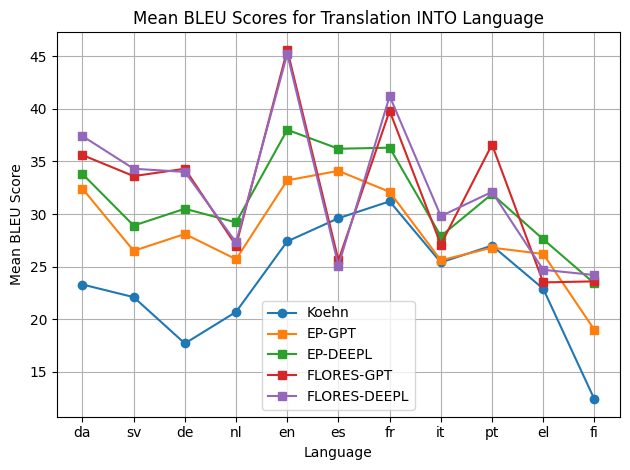

In [167]:
import matplotlib.pyplot as plt

# Assume same language order
langs = df_into['lang']
x = range(len(langs))

# Different BLEU score sets
bleu_koehn = df_comb['koehn']
bleu_ep_gpt =  df_comb['koehn']+ df_comb['ep-gpt']
bleu_ep_deepl = df_comb['koehn'] + df_comb['ep-deepl']
bleu_flores_gpt = df_comb['koehn'] + df_comb['flores-gpt']
bleu_flores_deepl = df_comb['koehn'] + df_comb['flores-deepl']

# Plot all lines
plt.plot(x, bleu_koehn, marker='o', label='Koehn')
plt.plot(x, bleu_ep_gpt, marker='^', label='EP-GPT')
plt.plot(x, bleu_ep_deepl, marker='s', label='EP-DEEPL')
plt.plot(x, bleu_flores_gpt, marker='^', label='FLORES-GPT')
plt.plot(x, bleu_flores_deepl, marker='s', label='FLORES-DEEPL')


# Label x-axis with languages
plt.xticks(ticks=x, labels=langs)

# Add plot details
plt.title('Mean BLEU Scores for Translation INTO Language')
plt.xlabel('Language')
plt.ylabel('Mean BLEU Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [168]:
df_from = koehn_2005.mean(axis=1).round(1).reset_index()
df_from.columns = ['lang', 'koehn']
df_from

,lang,koehn
0,da,23.3
1,sv,24.8
2,de,22.2
3,nl,19.7
4,en,23.8
5,es,26.7
6,fr,26.1
7,it,24.3
8,pt,26.1
9,el,23.8


In [169]:
my_diffs = {}
for key in my_data:
    if key.startswith('opus'):
        continue
    df = my_data[key]['BLEU']
    diff = df.mean(axis=1).round(1) - koehn_2005.mean(axis=1).round(1)
    my_df_from = diff.round(1).reset_index()
    my_df_from.columns = ['lang', key]
    my_diffs[key] = my_df_from

In [170]:
import pandas as pd
dfs = [df_from, my_diffs['ep-gpt'], my_diffs['flores-gpt'],
       my_diffs['ep-deepl'], my_diffs['flores-deepl']]
dfs = [df.set_index('lang') for df in dfs]
df_comb = pd.concat(dfs, axis=1, join='inner')
df_comb

,koehn,ep-gpt,flores-gpt,ep-deepl,flores-deepl
lang,,,,,
da,23.3,5.8,11.9,9.0,12.0
sv,24.8,2.8,9.9,6.8,10.3
de,22.2,6.1,11.7,9.5,11.9
nl,19.7,6.1,7.2,8.2,8.3
en,23.8,5.0,15.5,9.7,15.4
es,26.7,4.1,-0.5,6.8,1.0
fr,26.1,2.7,6.5,4.7,6.5
it,24.3,1.1,3.6,4.5,4.0
pt,26.1,2.7,8.3,5.6,8.7


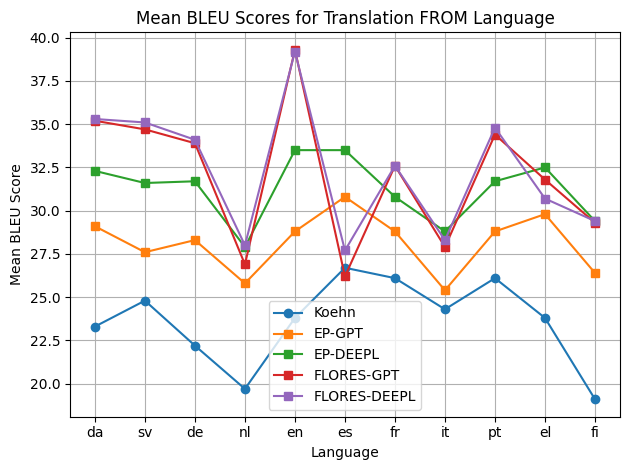

In [171]:
import matplotlib.pyplot as plt

# Assume same language order
langs = df_into['lang']
x = range(len(langs))

# Different BLEU score sets
bleu_koehn = df_comb['koehn']
bleu_ep_gpt = df_comb['koehn'] + df_comb['ep-gpt']
bleu_ep_deepl = df_comb['koehn'] + df_comb['ep-deepl']
bleu_flores_gpt = df_comb['koehn'] + df_comb['flores-gpt']
bleu_flores_deepl = df_comb['koehn'] + df_comb['flores-deepl']

# Plot all lines
plt.plot(x, bleu_koehn, marker='o', label='Koehn')
plt.plot(x, bleu_ep_gpt, marker='^', label='EP-GPT')
plt.plot(x, bleu_ep_deepl, marker='s', label='EP-DEEPL')
plt.plot(x, bleu_flores_gpt, marker='^', label='FLORES-GPT')
plt.plot(x, bleu_flores_deepl, marker='s', label='FLORES-DEEPL')


# Label x-axis with languages
plt.xticks(ticks=x, labels=langs)

# Add plot details
plt.title('Mean BLEU Scores for Translation FROM Language')
plt.xlabel('Language')
plt.ylabel('Mean BLEU Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [172]:
df_diff = koehn_2005.mean(axis=1) - koehn_2005.mean()
df_diff = df_diff.round(1).reset_index()
df_diff.columns = ['lang', 'koehn']
df_diff

,lang,koehn
0,da,0.0
1,sv,2.6
2,de,4.5
3,nl,-1.1
4,en,-3.6
5,es,-2.9
6,fr,-5.1
7,it,-1.1
8,pt,-0.9
9,el,0.9


In [173]:
my_diffs = {}
for key in my_data:
    if key.startswith('opus'):
        continue
    df = my_data[key]['BLEU']
    diff = df.mean(axis=1) - df.mean()
    diff = diff.round(1).reset_index()
    diff.columns = ['lang', key]
    my_diffs[key] = diff

In [174]:
import pandas as pd
dfs = [df_diff, my_diffs['ep-gpt'], my_diffs['flores-gpt'],
       my_diffs['ep-deepl'], my_diffs['flores-deepl']]
dfs = [df.set_index('lang') for df in dfs]
df_comb = pd.concat(dfs, axis=1, join='inner')
df_comb

,koehn,ep-gpt,flores-gpt,ep-deepl,flores-deepl
lang,,,,,
da,0.0,-3.3,-0.4,-1.5,-2.1
sv,2.6,1.1,1.1,2.7,0.8
de,4.5,0.2,-0.4,1.1,0.1
nl,-1.1,0.1,-0.1,-1.3,0.8
en,-3.6,-4.3,-6.3,-4.5,-6.0
es,-2.9,-3.3,0.6,-2.6,2.6
fr,-5.1,-3.3,-7.2,-5.5,-8.6
it,-1.1,-0.2,0.8,1.0,-1.5
pt,-0.9,2.0,-2.2,-0.2,2.7


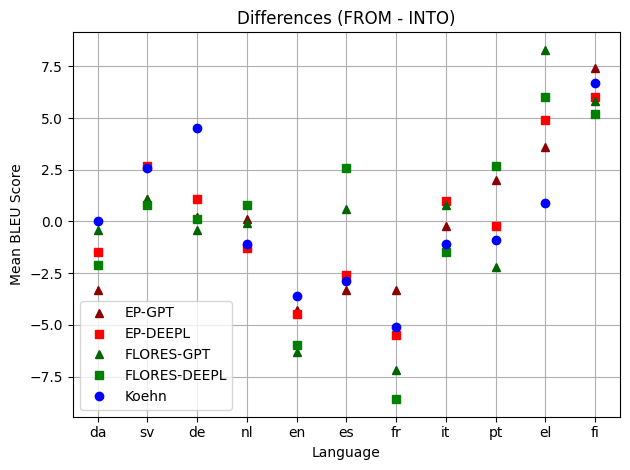

In [185]:
import matplotlib.pyplot as plt

# Assume same language order
langs = df_into['lang']
x = range(len(langs))

# Different BLEU score sets
bleu_koehn = df_comb['koehn']
bleu_ep_gpt =  df_comb['ep-gpt']
bleu_ep_deepl =  df_comb['ep-deepl']
bleu_flores_gpt =  df_comb['flores-gpt']
bleu_flores_deepl = df_comb['flores-deepl']

# Plot all lines

plt.plot(x, bleu_ep_gpt, marker='^', linestyle='None',
         color='darkred', label='EP-GPT')
plt.plot(x, bleu_ep_deepl, marker='s', linestyle='None',
         color='red', label='EP-DEEPL')
plt.plot(x, bleu_flores_gpt, marker='^', linestyle='None',
         color='darkgreen', label='FLORES-GPT')
plt.plot(x, bleu_flores_deepl, marker='s', linestyle='None',
         color='green', label='FLORES-DEEPL')
plt.plot(x, bleu_koehn, marker='o', linestyle='None',
         color='blue', label='Koehn')

# Label x-axis with languages
plt.xticks(ticks=x, labels=langs)

# Add plot details
plt.title('Differences (FROM - INTO)')
plt.xlabel('Language')
plt.ylabel('Mean BLEU Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

* Positive: Easier to translate FROM
* Negative: Easier to translate INTO